# Threshold Approaches: Eliminating Features which have more than 50% and 25% Missing Value

In [1]:
# importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
import sys
from impyute.imputation.cs import fast_knn
from impyute.imputation.cs import mice
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Tree Visualization
from sklearn.tree import export_graphviz

# Scores
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Ignoring Errors
import warnings
warnings.simplefilter('ignore')

In [2]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scoring = make_scorer(f1_score, pos_label=1, average='macro')
def find_best(classifier, X_train, y_train, param_grid, scoring=scoring):
    gs = GridSearchCV(estimator=classifier, 
                      param_grid=param_grid, 
                      scoring=scoring,
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return (gs.best_score_, gs.best_params_, gs.best_estimator_)

# Finding roc_curve and Auc score for each classifier
def find_roccurve(classifier,X_train,X_test,y_train,y_test):
    classifier.fit(X_train, y_train)
    y_prob = classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    # print('AUC: %.2f' % auc)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    return (auc, fpr, tpr, thresholds)

In [3]:
def find_val_score(classifier, X, y):
    all_f1_scores = []
    kf = StratifiedKFold(10, random_state=0)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        all_f1_scores.append(f1_score(y_test, y_pred, pos_label=1, average='macro'))
    
    all_f1_scores = np.ravel(all_f1_scores)
    return (all_f1_scores.mean(), all_f1_scores.std())

In [4]:
def return_roc_curves(classifiers, X_train, X_test, y_train, y_test):
    lr_score = find_roccurve(classifiers[0], X_train, X_test, y_train, y_test)
    svm_score = find_roccurve(classifiers[1], X_train, X_test, y_train, y_test)
    knn_score = find_roccurve(classifiers[2], X_train, X_test, y_train, y_test)
    dt_score = find_roccurve(classifiers[3], X_train, X_test, y_train, y_test)
    
    return (lr_score, svm_score, knn_score, dt_score)

In [5]:
def plot_roc_curves(roc_scores, num, threshold, save=False):
    knn_scores = roc_scores[num]['knn']
    mice_scores = roc_scores[num]['mice']
    names = roc_scores[num]['name']

    scores = {'knn':[knn_scores[0], knn_scores[1], knn_scores[2], knn_scores[3]],
              'mice':[mice_scores[0],mice_scores[1],mice_scores[2], mice_scores[3]]}

    class_names = {'knn':'KNN-Based Imputation',
                   'mice':'MICE Imputation'}

    classifier_names = ['LR', 'SVM', 'KNN', 'DT']
    clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax = np.ravel(ax)
    for idx, key in zip([0,1], class_names.keys()):
        data = scores[key]
        for name, clor, score_idx in zip(classifier_names, clr[1:5], range(4)):
            inf = data[score_idx]
            ax[idx].plot(inf[1], inf[2], color=clor, label='{}: {}'.format(name, round(inf[0],2)))
        ax[idx].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        ax[idx].legend()
        ax[idx].set_xlabel('False Positive Rate')
        ax[idx].set_ylabel('True Positive Rate')
        ax[idx].title.set_text("Roc Curves For {}".format(class_names[key]))
    fig.suptitle('Roc Curves of <{}% Missing Values on\n\"{}\" column'.format(threshold, names), y=1.02, fontsize=14)
    if save:
        fig.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
def return_f1_scores(X, y, X_train, y_train):
    pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(random_state=0, n_jobs=-1)]])
    pipe_svm = Pipeline([['sc', StandardScaler()], ['clf', SVC(probability=True)]])
    pipe_knn = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_jobs=-1)]])
    pipe_dt = Pipeline([['sc', StandardScaler()], ['clf', DecisionTreeClassifier(random_state=0)]])

    lr_grid = [{'clf__C': param_range,
                'clf__penalty': ['l1','l2']}]

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    knn_grid = [{'clf__n_neighbors': [5, 10, 30, 50]}]
    
    dt_grid = [{'clf__max_depth': [None, 1, 2, 3]}]

    lr_params = find_best(pipe_lr, X_train, y_train, lr_grid)
    svm_params = find_best(pipe_svm, X_train, y_train, svm_grid)
    knn_params = find_best(pipe_knn, X_train, y_train, knn_grid)
    dt_params = find_best(pipe_dt, X_train, y_train, dt_grid)

    lr_score = find_val_score(lr_params[2], X, y)
    svm_score = find_val_score(svm_params[2], X, y)
    knn_score = find_val_score(knn_params[2], X, y)
    dt_score = find_val_score(dt_params[2], X, y)

    return (lr_score, svm_score, knn_score, dt_score, (lr_params[2], svm_params[2], knn_params[2], dt_params[2]))

In [7]:
def plot_f1_scores(f1_scores, num, threshold, save=False):
    knn_scores = f1_scores[num]['knn']
    mice_scores = f1_scores[num]['mice']
    name = f1_scores[num]['name']

    scores = {'knn':[knn_scores[0], knn_scores[1], knn_scores[2], knn_scores[3]],
              'mice':[mice_scores[0],mice_scores[1],mice_scores[2], mice_scores[3]]}

    class_names = {'knn':'KNN-Based Imputation F1-Scores',
                   'mice':'MICE Imputation F1-Scores'}

    classifier_names = ['LR', 'SVM', 'KNN', 'DT']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
    clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
    for idx, mthod in zip([i for i in range(2)], scores.keys()):
        ax[idx].bar(classifier_names, [round(i[0]*100,2) for i in scores[mthod]], 
                               align='center', alpha=1.0, color=clr)
        ax[idx].set_yticks([i for i in range(0,110,10)])
        legends = []
        for i in range(len(classifier_names)):
            legends.append(mpatches.Patch(color=clr[i], label='{}: {}'.format(classifier_names[i], 
                                                                              round(scores[mthod][i][0]*100,2))))
        ax[idx].legend(handles=legends,loc='best')
        ax[idx].set_xlabel('Classifiers')
        ax[idx].set_ylabel('F1 Scores')
        ax[idx].title.set_text(class_names[mthod])
    # fig.tight_layout()
    fig.suptitle('F1-Scores of <{}% Missing Values on\n\"{}\" column'.format(threshold, name),
                 y=1.03, fontsize=16)
    if save:
        fig.savefig(save, dpi=300, bbox_inches='tight')

In [8]:
def calculate_error_scores(X_train, X_test, y_train, y_test, regressor):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mae_score = mean_absolute_error(y_test, y_pred)
    mse_score = mean_squared_error(y_test, y_pred)
    r2_score_ = r2_score(y_test, y_pred)
    return (mae_score, mse_score, r2_score_)

In [9]:
def return_error_scores(X_train, X_test, y_train, y_test):
    pipe_lr_reg = Pipeline([['sc', StandardScaler()], ['clf', LinearRegression(n_jobs=-1)]])
    pipe_svr_reg = Pipeline([['sc', StandardScaler()], ['clf', SVR()]])
    pipe_knn_reg = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsRegressor(n_jobs=-1)]])
    pipe_dt_reg = Pipeline([['sc', StandardScaler()], ['clf', DecisionTreeRegressor(random_state=0)]])

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    knn_grid = [{'clf__n_neighbors': [5, 10, 30, 50]}]
    
    dt_grid = [{'clf__max_depth': [None, 1, 2, 3]}]

    svr_params = find_best(pipe_svr_reg, X_train, y_train, svm_grid, scoring='neg_mean_absolute_error')
    knn_params = find_best(pipe_knn_reg, X_train, y_train, knn_grid, scoring='neg_mean_absolute_error')
    dt_params = find_best(pipe_dt_reg, X_train, y_train, dt_grid, scoring='neg_mean_absolute_error')

    lr_errors = calculate_error_scores(X_train, X_test, y_train, y_test, pipe_lr_reg)
    svr_errors = calculate_error_scores(X_train, X_test, y_train, y_test, svr_params[2])
    knn_errors = calculate_error_scores(X_train, X_test, y_train, y_test, knn_params[2])
    dt_errors = calculate_error_scores(X_train, X_test, y_train, y_test, dt_params[2])

    return (lr_errors, svr_errors, knn_errors, dt_errors, (pipe_lr_reg, svr_params[2], knn_params[2], dt_params[2]))

In [10]:
def plot_error_scores(error_scores, num, title, save=False):
    scores = error_scores[num]['score']
    name = error_scores[num]['name']
    scores = {'lr':[scores['lr'][0], scores['lr'][1], scores['lr'][2]],
             'svr':[scores['svr'][0], scores['svr'][1], scores['svr'][2]],
             'knn':[scores['knn'][0], scores['knn'][1], scores['knn'][2]],
             'dt':[scores['dt'][0], scores['dt'][1], scores['dt'][2]]}
    
    class_names = {'lr': 'LinearRegression', 'svr': 'SupportVector Regressor',
                   'knn':'KNN Regressor', 'dt':'DecisionTree Regressor'}

    scores_names = ['MAE', 'MSE', 'R2']

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
    ax = np.ravel(ax)
    clr = ('orange','blue', 'green', 'purple', 'red', 'purple')
    for idx, mthod in zip([i for i in range(4)], scores.keys()):
        ax[idx].bar(scores_names, [round(i,3) for i in scores[mthod]], 
                               align='center', alpha=1.0, color=clr)
        ax[idx].set_yticks([a for a in range(0,4)])
        legends = []
        for c in range(len(scores_names)):
            legends.append(mpatches.Patch(color=clr[c], label='{}: {}'.format(scores_names[c], 
                                                                              round(scores[mthod][c],3))))
        ax[idx].legend(handles=legends,loc='best')
        ax[idx].set_xlabel('Error Algorithms')
        ax[idx].set_ylabel("Error Algorithms' Scores")
        ax[idx].title.set_text('MAE, MSE & R2 Scores By {}'.format(class_names[mthod]))
    fig.suptitle('Error Scores of {} For \"{}\" column'.format(title, name),y=1.02, fontsize=16)
    fig.tight_layout()
    if save:
        fig.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
def return_confusion(classifiers, X_train, X_test, y_train, y_test):
    confmats = []
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        confmats.append(confmat)
    return confmats

In [12]:
def plot_confusion(confmats, num, threshold, save=False):
    scores = confmats[num]['score']
    name = confmats[num]['name']
    
    plt.figure(figsize=(6,6))
    for ax_num, classifier in zip([221,222,223,224], scores.keys()):
        ax = plt.subplot(ax_num)
        ax.title.set_text(classifier)
        confmat = scores[classifier]

        ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
        plt.xlabel('predicted label')
        plt.ylabel('true label')

    plt.suptitle('Confusion Matrix of <{}% Missing Values on\n\"{}\" column'.format(threshold, name) ,y=1.05, fontsize=16)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()

## Importing Data and Some Data Pre-Processing

In [13]:
data = pd.read_excel("NAFLD_en.xlsx")
features_df = data.iloc[:,1:-9]
targets_df = data.iloc[:,-9:]

for clm in targets_df.columns[-2:]:
    targets_df[clm] = targets_df[clm].map({1:0, 2:1})

features_df = features_df.drop(['Steatosis', 'Activity'], 1)

In [14]:
missing_data_percentages = features_df.isnull().mean()
threshold_25 = [col for col, persantage in missing_data_percentages.items() if persantage < 0.25]
threshold_50 = [col for col, persantage in missing_data_percentages.items() if persantage < 0.5]
threshold_25_df = features_df[threshold_25]
threshold_50_df = features_df[threshold_50]

## Columns have less than 25% missing values

In [15]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
knn_25 = fast_knn(threshold_25_df.values, k=30)
mice_25 = mice(threshold_25_df.values)

In [16]:
# F1-Scores For Each Target
threshold_25_f1_scores = {}
threshold_25_roc_curves = {}
threshold_25_confmat = {}
for num, name in enumerate(targets_df.columns[2:]):
    target = targets_df[name].values
    name = name.split('(')[0].strip()
    X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(knn_25, target,
                                                                    test_size = 0.3, random_state = 0)
    X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(mice_25, target,
                                                                    test_size = 0.3, random_state = 0)
    
    knn_f1_scores = return_f1_scores(knn_25, target, X_train_knn, y_train_knn)
    mice_f1_scores = return_f1_scores(mice_25, target, X_train_mice, y_train_mice)
    knn_roc_curves = return_roc_curves(knn_f1_scores[4], X_train_knn, X_test_knn, y_train_knn, y_test_knn)
    mice_roc_curves = return_roc_curves(mice_f1_scores[4], X_train_mice, X_test_mice, y_train_mice, y_test_mice)
    mice_confusion = return_confusion(mice_f1_scores[4], X_train_mice, X_test_mice, y_train_mice, y_test_mice)
    
    threshold_25_f1_scores[num] = {'name':name, 'knn':knn_f1_scores, 'mice':mice_f1_scores}
    threshold_25_roc_curves[num] = {'name':name, 'knn':knn_roc_curves, 'mice':mice_roc_curves}
    threshold_25_confmat[num] = {'name':name, 'score':{'LR':mice_confusion[0],'SVM':mice_confusion[1],
                                                         'KNN':mice_confusion[2], 'DT':mice_confusion[3]}}
    if num == 0:
        fitted_dt = mice_f1_scores[4][3]
        fitted_dt.fit(X_train_mice, y_train_mice)
        
        export_graphviz(fitted_dt['clf'], out_file='tree_25.dot', filled=True, rounded=True, 
                        special_characters=True)

### F1 Scores

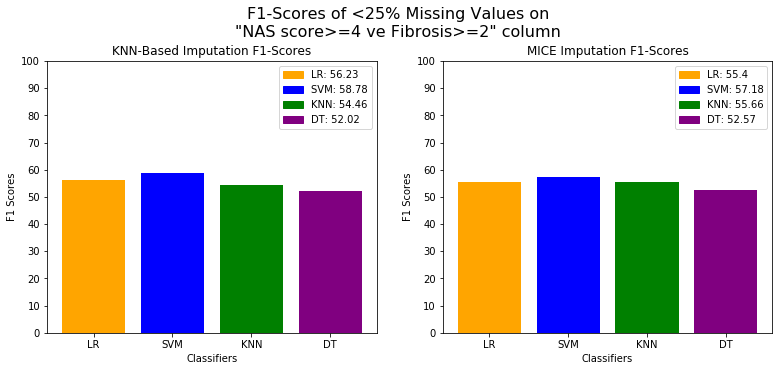

In [17]:
plot_f1_scores(threshold_25_f1_scores, 0, 25, save='threshold_25_f1_0')

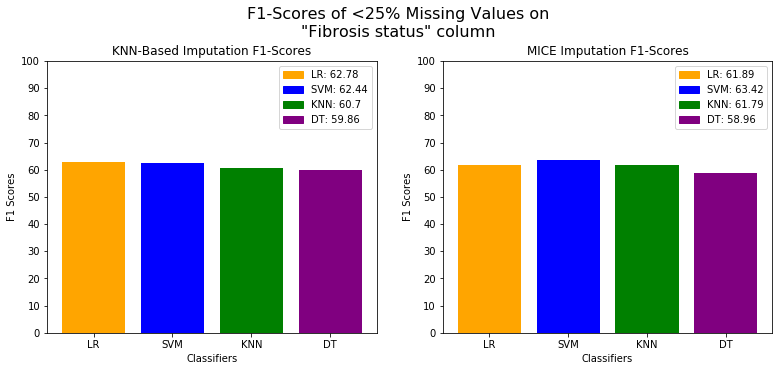

In [18]:
plot_f1_scores(threshold_25_f1_scores, 1, 25, save='threshold_25_f1_1')

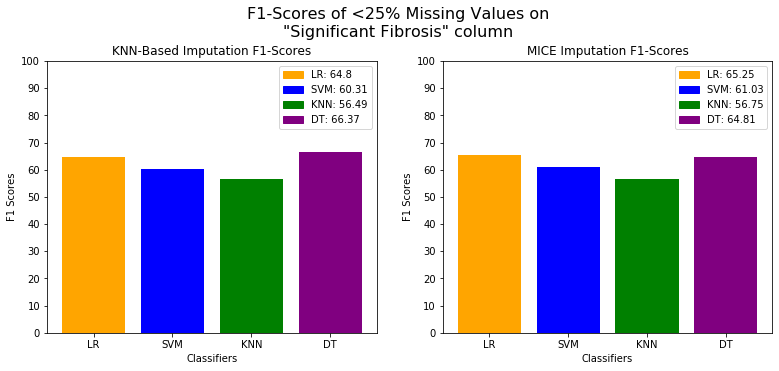

In [19]:
plot_f1_scores(threshold_25_f1_scores, 2, 25, save='threshold_25_f1_2')

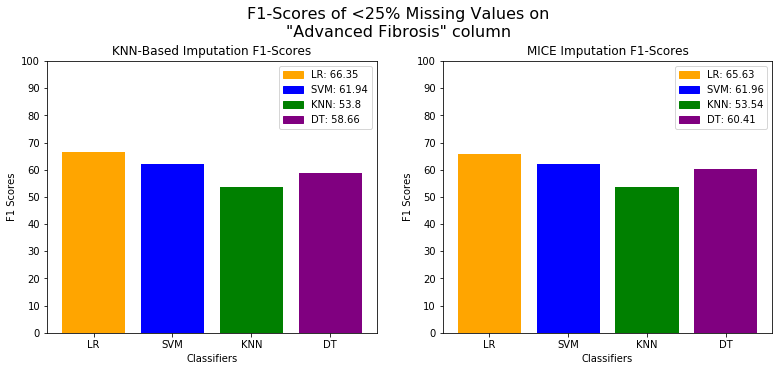

In [20]:
plot_f1_scores(threshold_25_f1_scores, 3, 25, save='threshold_25_f1_3')

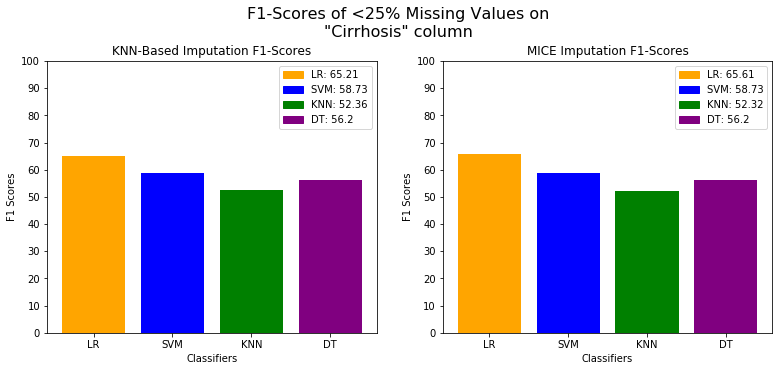

In [21]:
plot_f1_scores(threshold_25_f1_scores, 4, 25, save='threshold_25_f1_4')

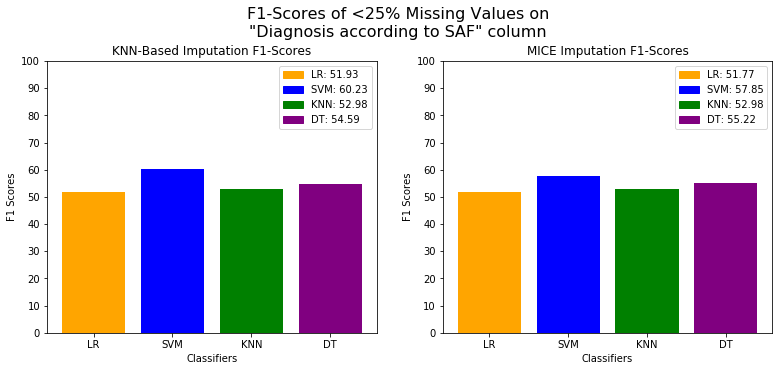

In [22]:
plot_f1_scores(threshold_25_f1_scores, 5, 25, save='threshold_25_f1_5')

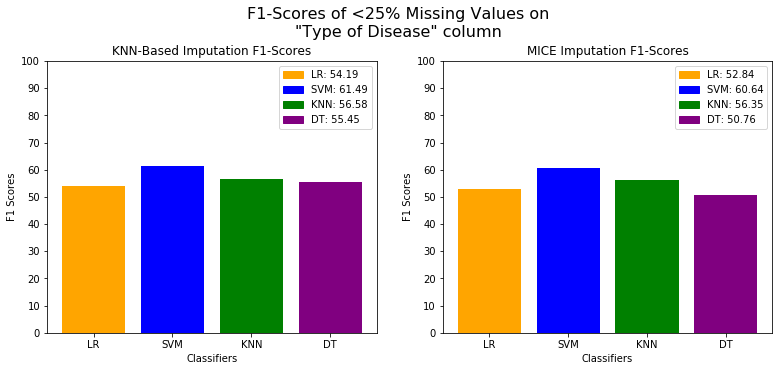

In [23]:
plot_f1_scores(threshold_25_f1_scores, 6, 25, save='threshold_25_f1_6')

### Error Scores

In [24]:
# Error Scores For BB & BC Target With MICE Imputation
mice_25_error_scores = {}
for num, name in enumerate(targets_df.columns[:2]):
    target = targets_df[name].values
    X_train, X_test, y_train, y_test = train_test_split(mice_25, target, test_size = 0.3, random_state = 0)
    
    scores = return_error_scores(X_train, X_test, y_train, y_test)
    mice_25_error_scores[num] = {'name':name, 'score':{'lr':scores[0], 'svr':scores[1], 'knn':scores[2], 'dt':scores[3]}}

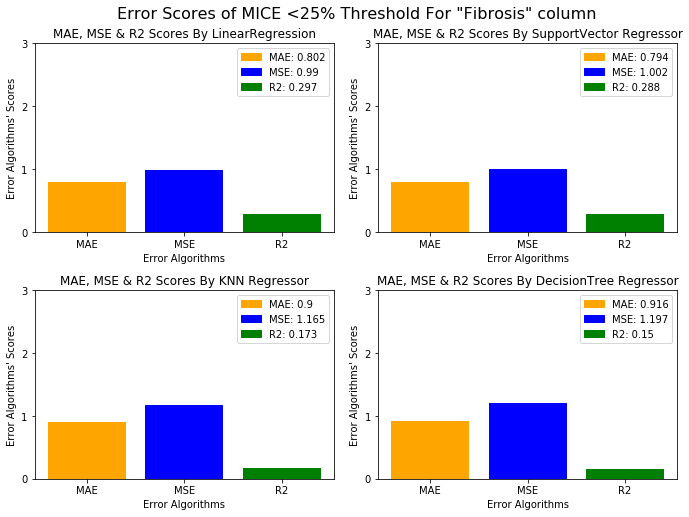

In [25]:
plot_error_scores(mice_25_error_scores, 0, 'MICE <25% Threshold', save='error_mice_25_bb')

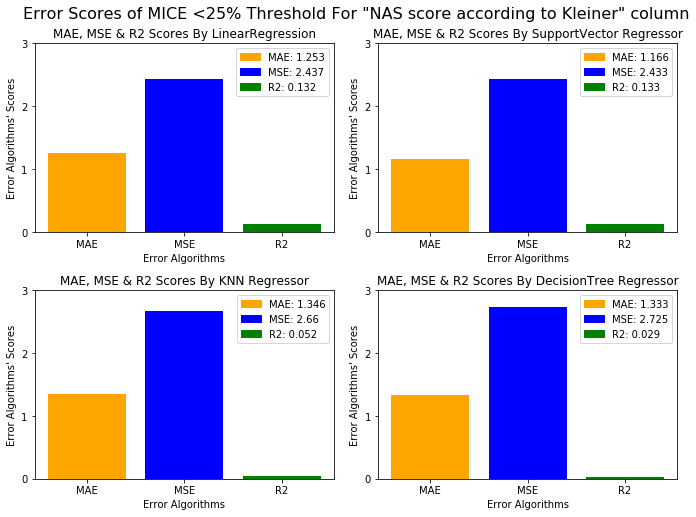

In [26]:
plot_error_scores(mice_25_error_scores, 1, 'MICE <25% Threshold', save='error_mice_25_bc')

### Roc Curves

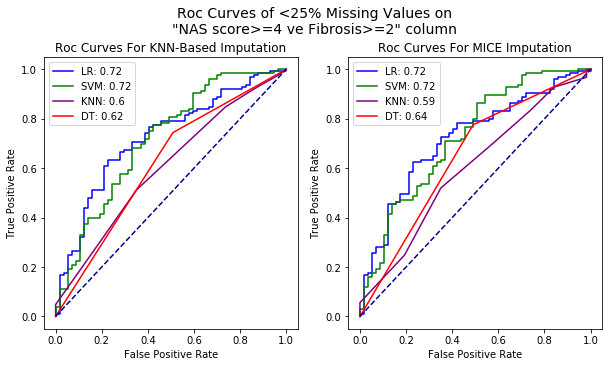

In [27]:
plot_roc_curves(threshold_25_roc_curves, 0, 25, save="threshold_25_roc_curve_0")

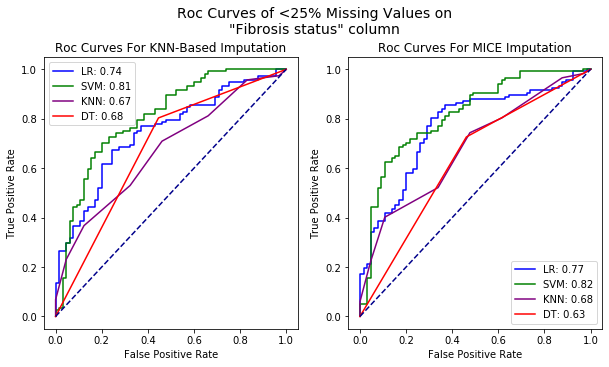

In [28]:
plot_roc_curves(threshold_25_roc_curves, 1, 25, save="threshold_25_roc_curve_1")

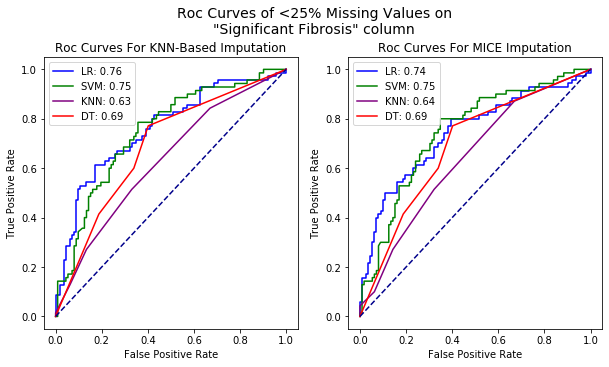

In [29]:
plot_roc_curves(threshold_25_roc_curves, 2, 25, save="threshold_25_roc_curve_2")

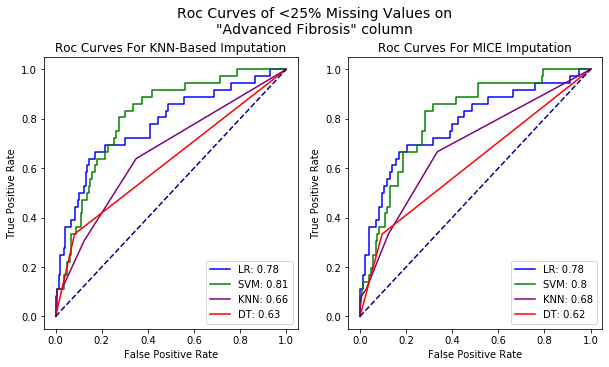

In [30]:
plot_roc_curves(threshold_25_roc_curves, 3, 25, save="threshold_25_roc_curve_3")

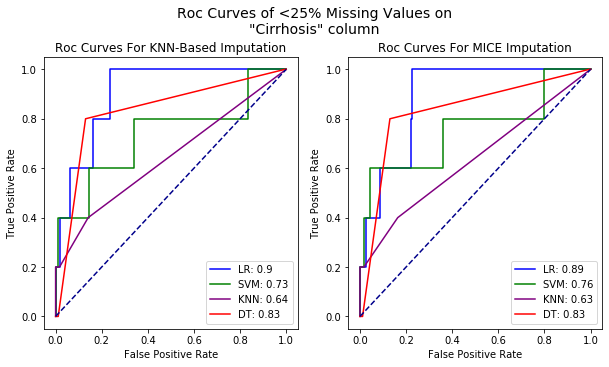

In [31]:
plot_roc_curves(threshold_25_roc_curves, 4, 25, save="threshold_25_roc_curve_4")

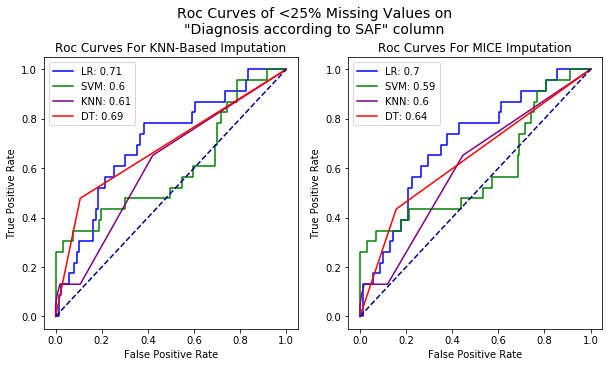

In [32]:
plot_roc_curves(threshold_25_roc_curves, 5, 25, save="threshold_25_roc_curve_5")

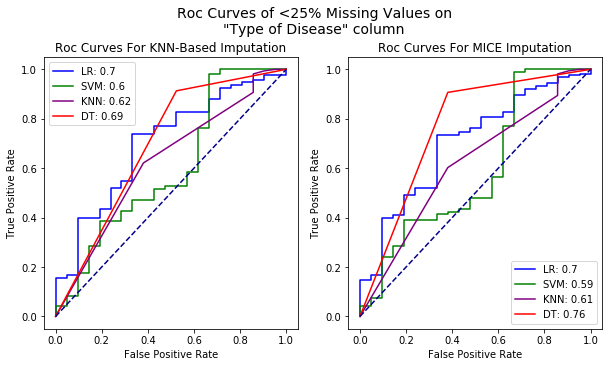

In [33]:
plot_roc_curves(threshold_25_roc_curves, 6, 25, save="threshold_25_roc_curve_6")

### Confusion Matrices

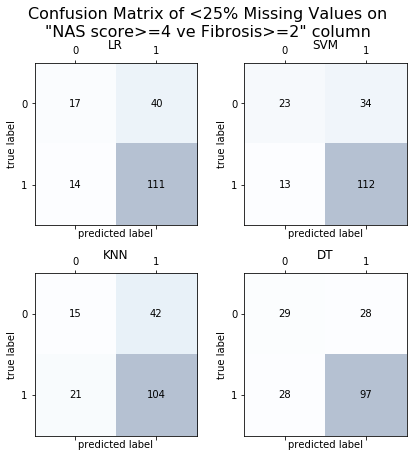

In [34]:
plot_confusion(threshold_25_confmat, 0, 25, save="threshold_25_confmat_0")

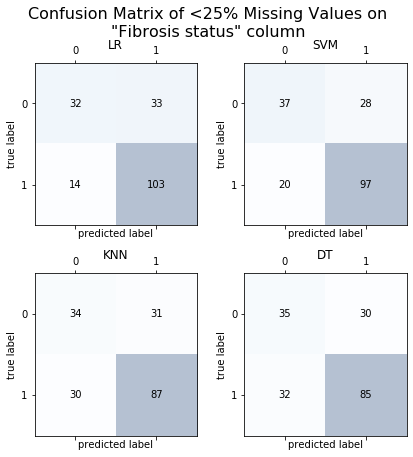

In [35]:
plot_confusion(threshold_25_confmat, 1, 25, save="threshold_25_confmat_1")

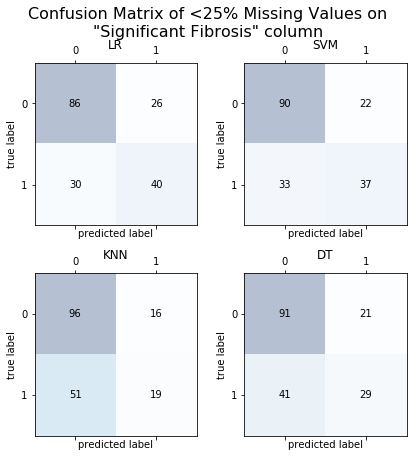

In [36]:
plot_confusion(threshold_25_confmat, 2, 25, save="threshold_25_confmat_2")

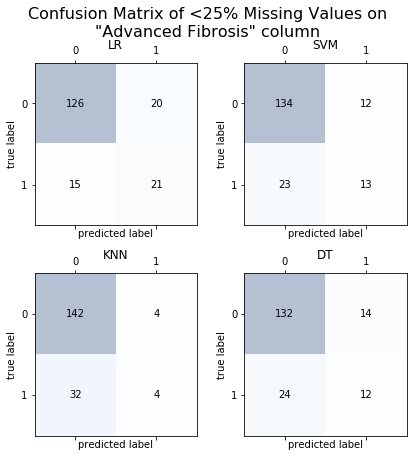

In [37]:
plot_confusion(threshold_25_confmat, 3, 25, save="threshold_25_confmat_3")

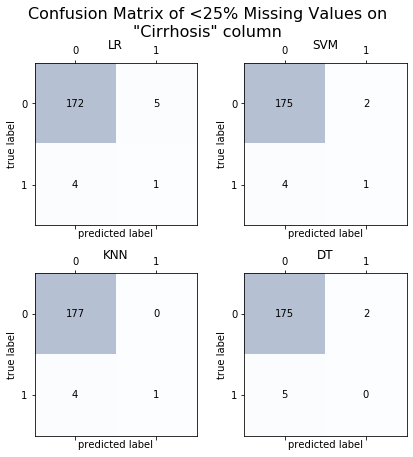

In [38]:
plot_confusion(threshold_25_confmat, 4, 25, save="threshold_25_confmat_4")

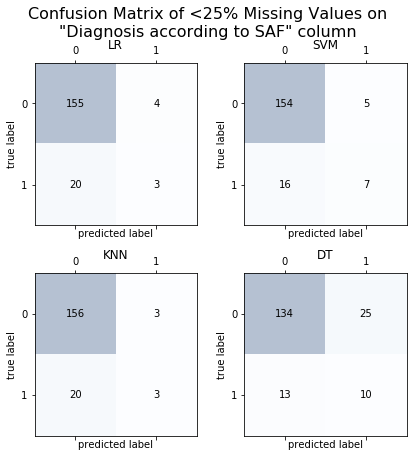

In [39]:
plot_confusion(threshold_25_confmat, 5, 25, save="threshold_25_confmat_5")

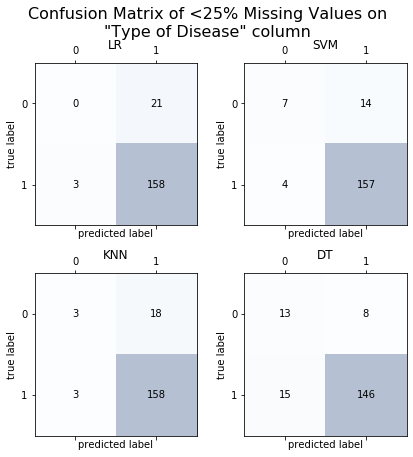

In [40]:
plot_confusion(threshold_25_confmat, 6, 25, save="threshold_25_confmat_6")

## Columns have less than 50% missing values

In [41]:
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
knn_50 = fast_knn(threshold_50_df.values, k=30)
mice_50 = mice(threshold_50_df.values)

In [42]:
# F1-Scores For Each Target
threshold_50_f1_scores = {}
threshold_50_roc_curves = {}
threshold_50_confmat = {}
for num, name in enumerate(targets_df.columns[2:]):
    target = targets_df[name].values
    name = name.split('(')[0].strip()
    X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(knn_50, target,
                                                                    test_size = 0.3, random_state = 0)
    X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(mice_50, target,
                                                                    test_size = 0.3, random_state = 0)
    
    knn_f1_scores = return_f1_scores(knn_50, target, X_train_knn, y_train_knn)
    mice_f1_scores = return_f1_scores(mice_50, target, X_train_mice, y_train_mice)
    knn_roc_curves = return_roc_curves(knn_f1_scores[4], X_train_knn, X_test_knn, y_train_knn, y_test_knn)
    mice_roc_curves = return_roc_curves(mice_f1_scores[4], X_train_mice, X_test_mice, y_train_mice, y_test_mice)
    mice_confusion = return_confusion(mice_f1_scores[4], X_train_mice, X_test_mice, y_train_mice, y_test_mice)
    
    threshold_50_f1_scores[num] = {'name':name, 'knn':knn_f1_scores, 'mice':mice_f1_scores}
    threshold_50_roc_curves[num] = {'name':name, 'knn':knn_roc_curves, 'mice':mice_roc_curves}
    threshold_50_confmat[num] = {'name':name, 'score':{'LR':mice_confusion[0],'SVM':mice_confusion[1],
                                                         'KNN':mice_confusion[2], 'DT':mice_confusion[3]}}
    if num == 0:
        fitted_dt = mice_f1_scores[4][3]
        fitted_dt.fit(X_train_mice, y_train_mice)
        
        export_graphviz(fitted_dt['clf'], out_file='tree_50.dot', filled=True, rounded=True, 
                        special_characters=True)

### F1 Scores

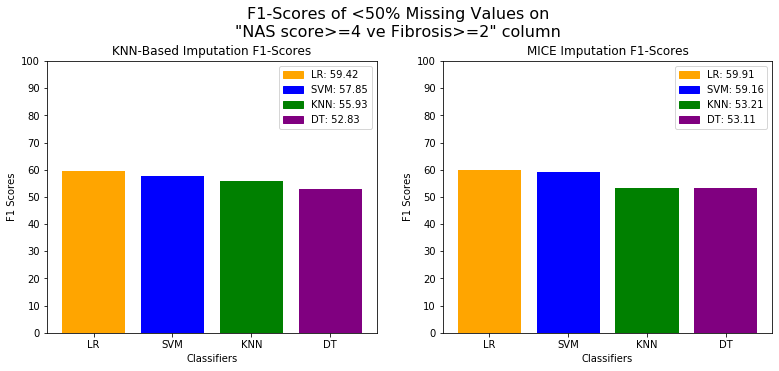

In [43]:
plot_f1_scores(threshold_50_f1_scores, 0, 50, save='threshold_50_f1_0')

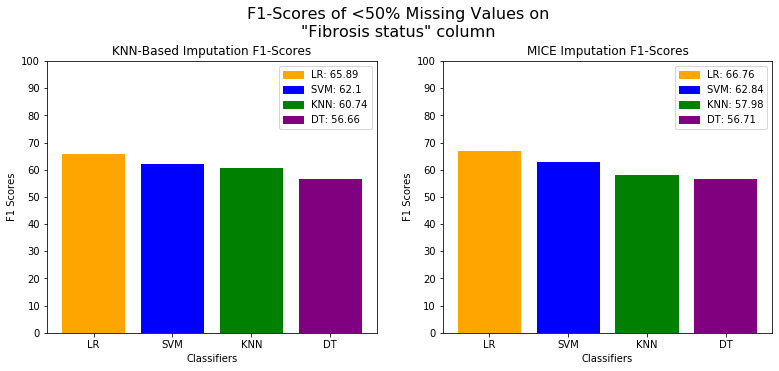

In [44]:
plot_f1_scores(threshold_50_f1_scores, 1, 50, save='threshold_50_f1_1')

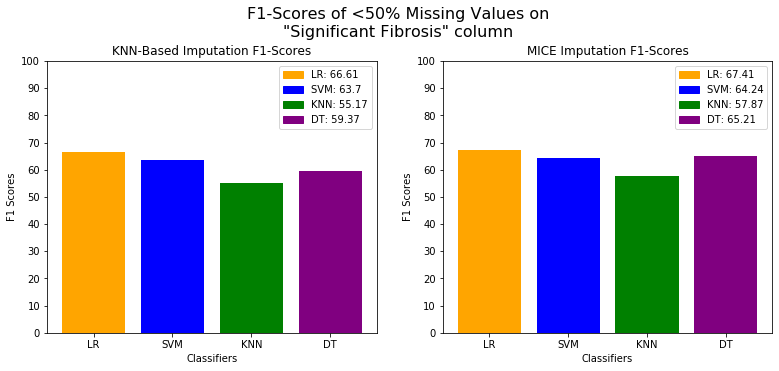

In [45]:
plot_f1_scores(threshold_50_f1_scores, 2, 50, save='threshold_50_f1_2')

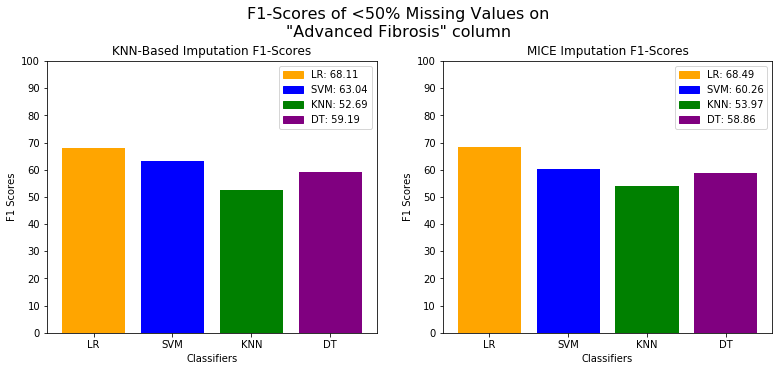

In [46]:
plot_f1_scores(threshold_50_f1_scores, 3, 50, save='threshold_50_f1_3')

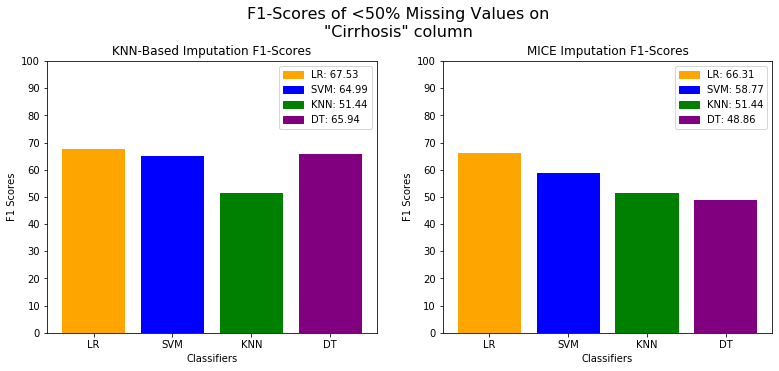

In [47]:
plot_f1_scores(threshold_50_f1_scores, 4, 50, save='threshold_50_f1_4')

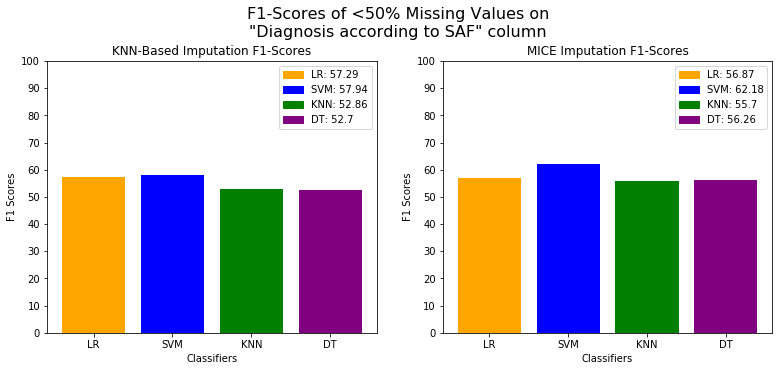

In [48]:
plot_f1_scores(threshold_50_f1_scores, 5, 50, save='threshold_50_f1_5')

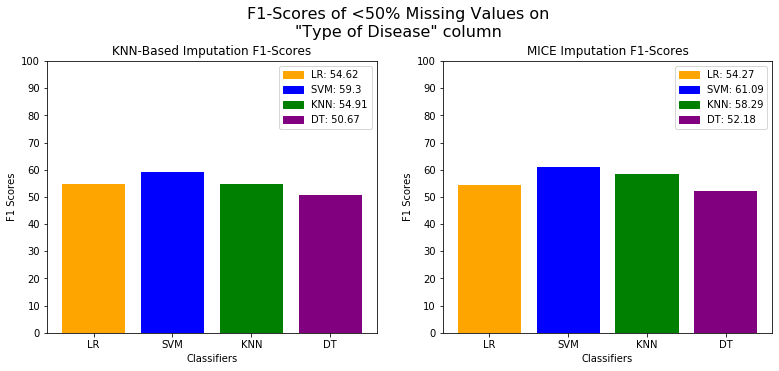

In [49]:
plot_f1_scores(threshold_50_f1_scores, 6, 50, save='threshold_50_f1_6')

### Error Scores

In [50]:
# Error Scores For BB & BC Target With MICE Imputation
mice_50_error_scores = {}
for num, name in enumerate(targets_df.columns[:2]):
    target = targets_df[name].values
    name = name.split('(')[0].strip()
    X_train, X_test, y_train, y_test = train_test_split(mice_50, target, test_size = 0.3, random_state = 0)
    
    scores = return_error_scores(X_train, X_test, y_train, y_test)
    mice_50_error_scores[num] = {'name':name, 'score':{'lr':scores[0], 'svr':scores[1], 'knn':scores[2], 'dt':scores[3]}}

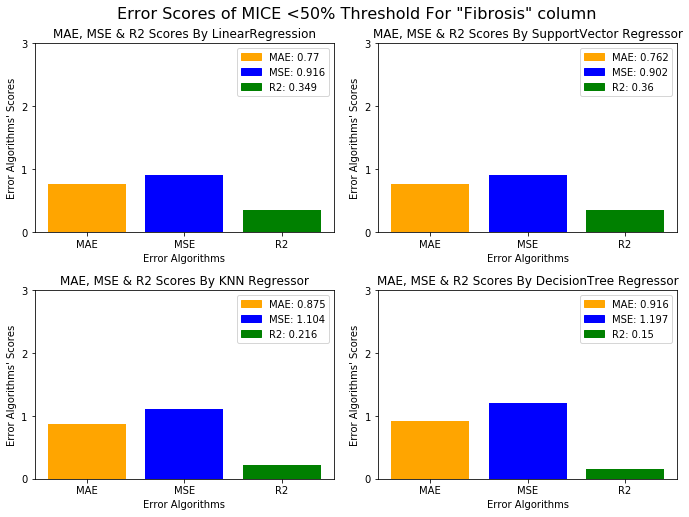

In [51]:
plot_error_scores(mice_50_error_scores, 0, 'MICE <50% Threshold', save='error_mice_50_bb')

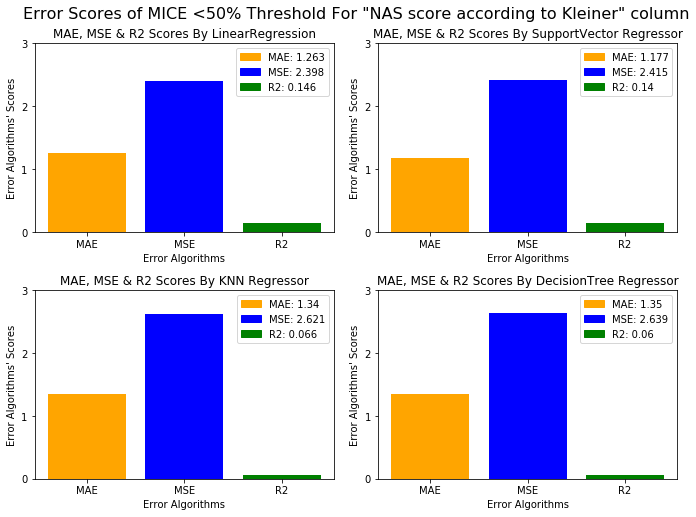

In [52]:
plot_error_scores(mice_50_error_scores, 1, 'MICE <50% Threshold', save='error_mice_50_bc')

### Roc Curves

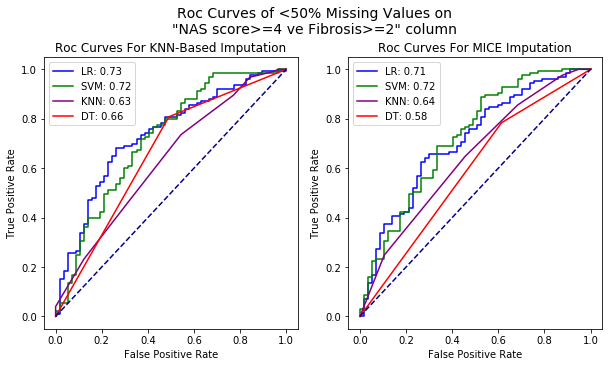

In [53]:
plot_roc_curves(threshold_50_roc_curves, 0, 50, save="threshold_50_roc_curve_0")

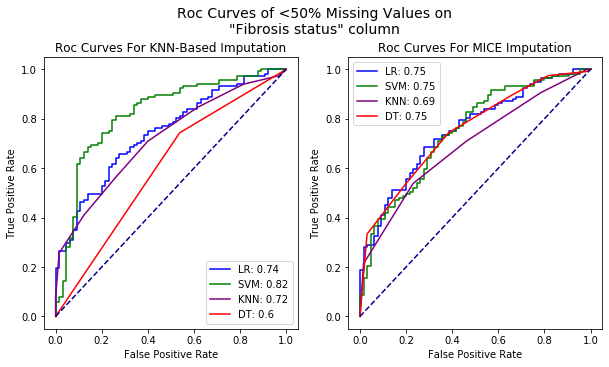

In [54]:
plot_roc_curves(threshold_50_roc_curves, 1, 50, save="threshold_50_roc_curve_1")

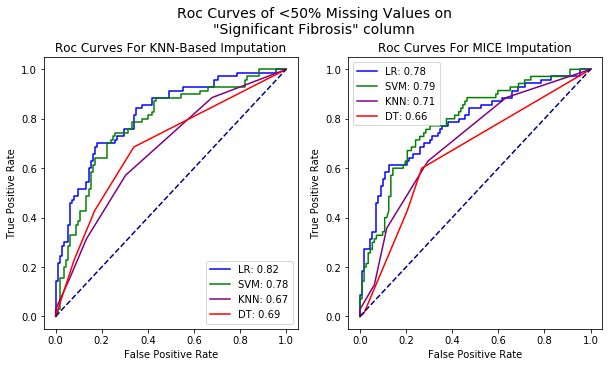

In [55]:
plot_roc_curves(threshold_50_roc_curves, 2, 50, save="threshold_50_roc_curve_2")

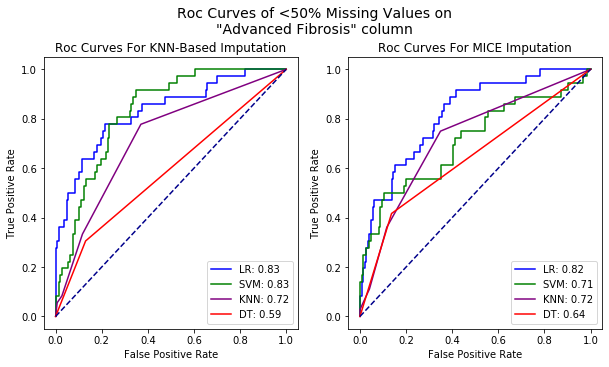

In [56]:
plot_roc_curves(threshold_50_roc_curves, 3, 50, save="threshold_50_roc_curve_3")

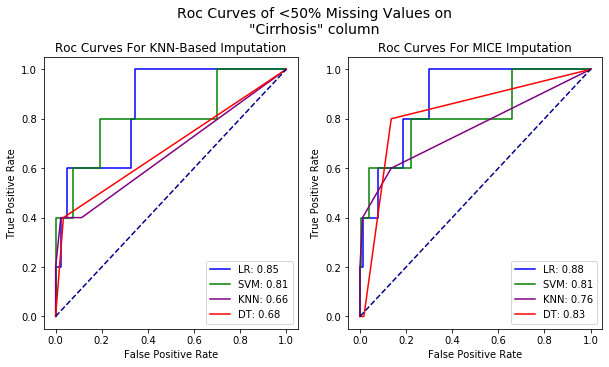

In [57]:
plot_roc_curves(threshold_50_roc_curves, 4, 50, save="threshold_50_roc_curve_4")

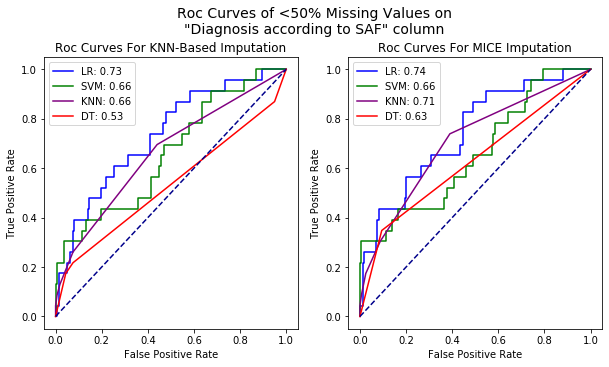

In [58]:
plot_roc_curves(threshold_50_roc_curves, 5, 50, save="threshold_50_roc_curve_5")

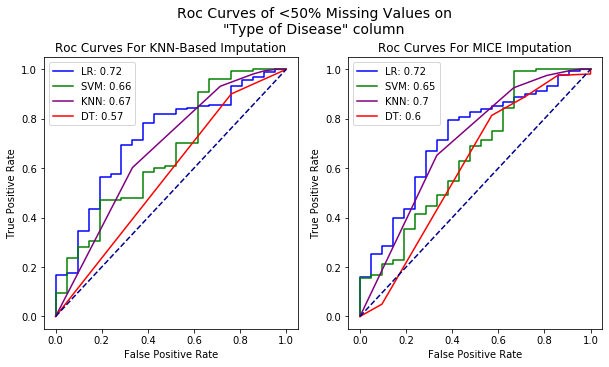

In [59]:
plot_roc_curves(threshold_50_roc_curves, 6, 50, save="threshold_50_roc_curve_6")

### Confusion Matrices

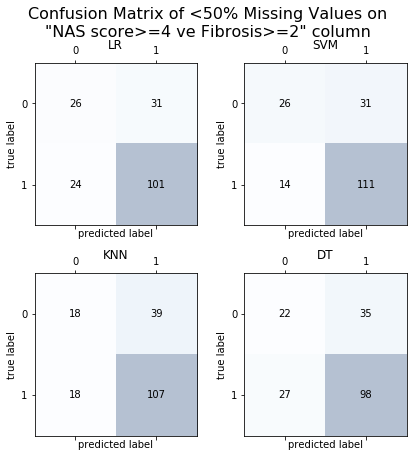

In [60]:
plot_confusion(threshold_50_confmat, 0, 50, save="threshold_50_confmat_0")

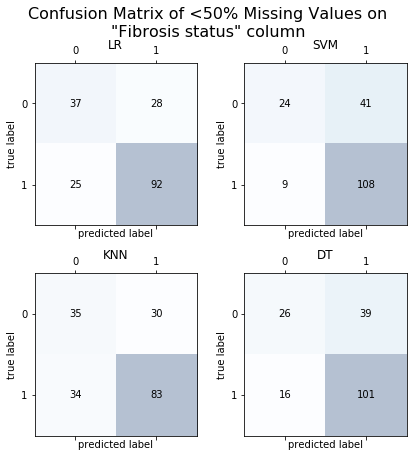

In [61]:
plot_confusion(threshold_50_confmat, 1, 50, save="threshold_50_confmat_1")

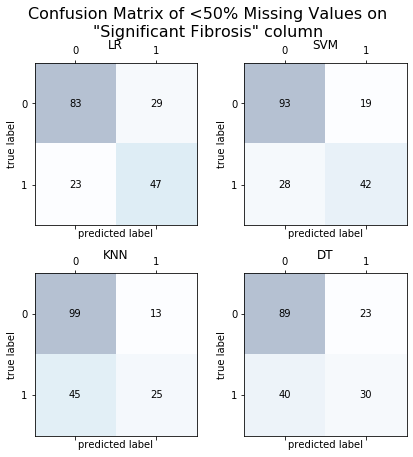

In [62]:
plot_confusion(threshold_50_confmat, 2, 50, save="threshold_50_confmat_2")

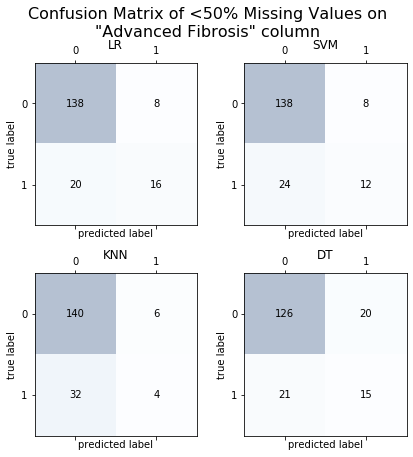

In [63]:
plot_confusion(threshold_50_confmat, 3, 50, save="threshold_50_confmat_3")

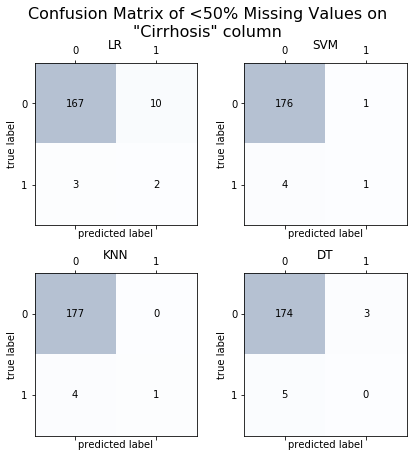

In [64]:
plot_confusion(threshold_50_confmat, 4, 50, save="threshold_50_confmat_4")

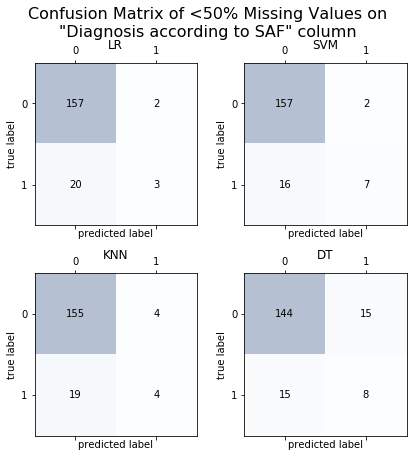

In [65]:
plot_confusion(threshold_50_confmat, 5, 50, save="threshold_50_confmat_5")

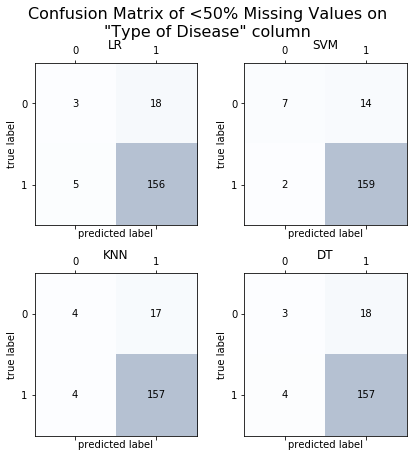

In [66]:
plot_confusion(threshold_50_confmat, 6, 50, save="threshold_50_confmat_6")